In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')

#'guide_identity'

In [6]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts

In [7]:
filt_ids = list(saveCounts['guide_identity'][saveCounts['cells'] >  50])
len(filt_ids)

290

In [8]:
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [[i] for i in filt_ids]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0', 'norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1', 'norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0', 'norman_allcrispr_TBX3_TBX2__TBX3_TBX2', 'norman_allcrispr_SLC4A1_NegCtrl0__SLC4A1_NegCtrl0', 'norman_allcrispr_ETS2_CNN1__ETS2_CNN1', 'norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2', 'norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2', 'norman_allcrispr_NegCtrl0_BAK1__NegCtrl0_BAK1', 'norman_allcrispr_NegCtrl0_KLF1__NegCtrl0_KLF1', 'norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2', 'norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0', 'norman_allcrispr_BAK1_NegCtrl0__BAK1_NegCtrl0', 'norman_allcrispr_SET_KLF1__SET_KLF1', 'norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE', 'norman_allcrispr_CBL_NegCtrl0__CBL_NegCtrl0', 'norman_allcri

## **Cell Preprocessing**

Dataset allcrispr. 
	116844 barcodes in loom, 94649 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1CAGCATATCTCAACTT-2TCCCGATGTAAACGCG-5ATGAGGGCATTGGCGC-2TAGGCATCACAGAGGT-

	['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0']: 3532 cells in annotations. 3532 in loom. 3255 pass filter.
	['NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0']: 2948 cells in annotations. 2948 in loom. 2679 pass filter.
	['NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0']: 2839 cells in annotations. 2839 in loom. 2622 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']: 2536 cells in annotations. 2536 in loom. 2362 pass filter.
	['CEBPE_RUNX1T1__CEBPE_RUNX1T1']: 1219 cells in annotations. 1219 in loom. 1018 pass filter.
	['KLF1_NegCtrl0__KLF1_NegCtrl0']: 1197 cells in annotations. 1197 in loom. 1109 pass filter.
	['TBX3_TBX2__TBX3_TBX2']: 1167 cells in annotations. 1167 in loom. 1028 pass filter.
	['SLC4A1_NegCtrl0__SLC4A1_NegCtrl0']: 1000 cells in annotations. 1000 in loom. 882 pass filter.
	['ETS2_CNN1__ETS2_CNN1']: 905 cells in annotations. 905 in loom. 798 pass filter.
	['UBASH3B_OSR2__UBASH3B_OSR2']: 796 cells in annotations. 796 in loom. 729 pass filter.
	['DUSP9_ETS2__DUSP9_ETS2']: 787 cells in ann

	['UBASH3B_CNN1__UBASH3B_CNN1']: 402 cells in annotations. 402 in loom. 292 pass filter.
	['NegCtrl0_TGFBR2__NegCtrl0_TGFBR2']: 401 cells in annotations. 401 in loom. 362 pass filter.
	['CNN1_MAPK1__CNN1_MAPK1']: 398 cells in annotations. 398 in loom. 329 pass filter.
	['KLF1_BAK1__KLF1_BAK1']: 395 cells in annotations. 395 in loom. 360 pass filter.
	['DLX2_NegCtrl0__DLX2_NegCtrl0']: 387 cells in annotations. 387 in loom. 333 pass filter.
	['FOSB_OSR2__FOSB_OSR2']: 382 cells in annotations. 382 in loom. 318 pass filter.
	['DUSP9_IGDCC3__DUSP9_IGDCC3']: 382 cells in annotations. 382 in loom. 286 pass filter.
	['ATL1_NegCtrl0__ATL1_NegCtrl0']: 379 cells in annotations. 379 in loom. 288 pass filter.
	['LHX1_NegCtrl0__LHX1_NegCtrl0']: 375 cells in annotations. 375 in loom. 306 pass filter.
	['NegCtrl0_FOXA1__NegCtrl0_FOXA1']: 372 cells in annotations. 372 in loom. 314 pass filter.
	['TBX3_NegCtrl0__TBX3_NegCtrl0']: 369 cells in annotations. 369 in loom. 334 pass filter.
	['NegCtrl0_UBASH3A

	['CNN1_NegCtrl0__CNN1_NegCtrl0']: 285 cells in annotations. 285 in loom. 251 pass filter.
	['NegCtrl0_FOXL2__NegCtrl0_FOXL2']: 284 cells in annotations. 284 in loom. 227 pass filter.
	['FEV_ISL2__FEV_ISL2']: 284 cells in annotations. 284 in loom. 153 pass filter.
	['PTPN12_SNAI1__PTPN12_SNAI1']: 283 cells in annotations. 283 in loom. 244 pass filter.
	['SAMD1_NegCtrl0__SAMD1_NegCtrl0']: 281 cells in annotations. 281 in loom. 210 pass filter.
	['KIAA1804_NegCtrl0__KIAA1804_NegCtrl0']: 278 cells in annotations. 278 in loom. 250 pass filter.
	['FEV_MAP7D1__FEV_MAP7D1']: 277 cells in annotations. 277 in loom. 193 pass filter.
	['AHR_FEV__AHR_FEV']: 276 cells in annotations. 276 in loom. 140 pass filter.
	['HOXA13_NegCtrl0__HOXA13_NegCtrl0']: 274 cells in annotations. 274 in loom. 173 pass filter.
	['FOXA1_FOXF1__FOXA1_FOXF1']: 272 cells in annotations. 272 in loom. 213 pass filter.
	['PTPN13_NegCtrl0__PTPN13_NegCtrl0']: 270 cells in annotations. 270 in loom. 237 pass filter.
	['NegCtrl0_C

	['PRDM1_CBFA2T3__PRDM1_CBFA2T3']: 106 cells in annotations. 106 in loom. 40 pass filter.
	['ZBTB10_SNAI1__ZBTB10_SNAI1']: 100 cells in annotations. 100 in loom. 42 pass filter.
	['KIF18B_KIF2C__KIF18B_KIF2C']: 96 cells in annotations. 96 in loom. 71 pass filter.
	['FOXL2_HOXB9__FOXL2_HOXB9']: 96 cells in annotations. 96 in loom. 52 pass filter.
	['HOXC13_NegCtrl0__HOXC13_NegCtrl0_2']: 91 cells in annotations. 91 in loom. 54 pass filter.
	['ZBTB10_DLX2__ZBTB10_DLX2']: 89 cells in annotations. 89 in loom. 42 pass filter.
	['ZBTB10_NegCtrl0__ZBTB10_NegCtrl0_1']: 86 cells in annotations. 86 in loom. 57 pass filter.
	['ZC3HAV1_CEBPA__ZC3HAV1_CEBPA']: 86 cells in annotations. 86 in loom. 50 pass filter.
	['PLK4_STIL__PLK4_STIL']: 81 cells in annotations. 81 in loom. 68 pass filter.
	['ZBTB10_NegCtrl0__ZBTB10_NegCtrl0_2']: 76 cells in annotations. 76 in loom. 48 pass filter.
	['HOXC13_NegCtrl0__HOXC13_NegCtrl0_1']: 76 cells in annotations. 76 in loom. 50 pass filter.
	['SAMD1_TGFBR2__SAMD1_T

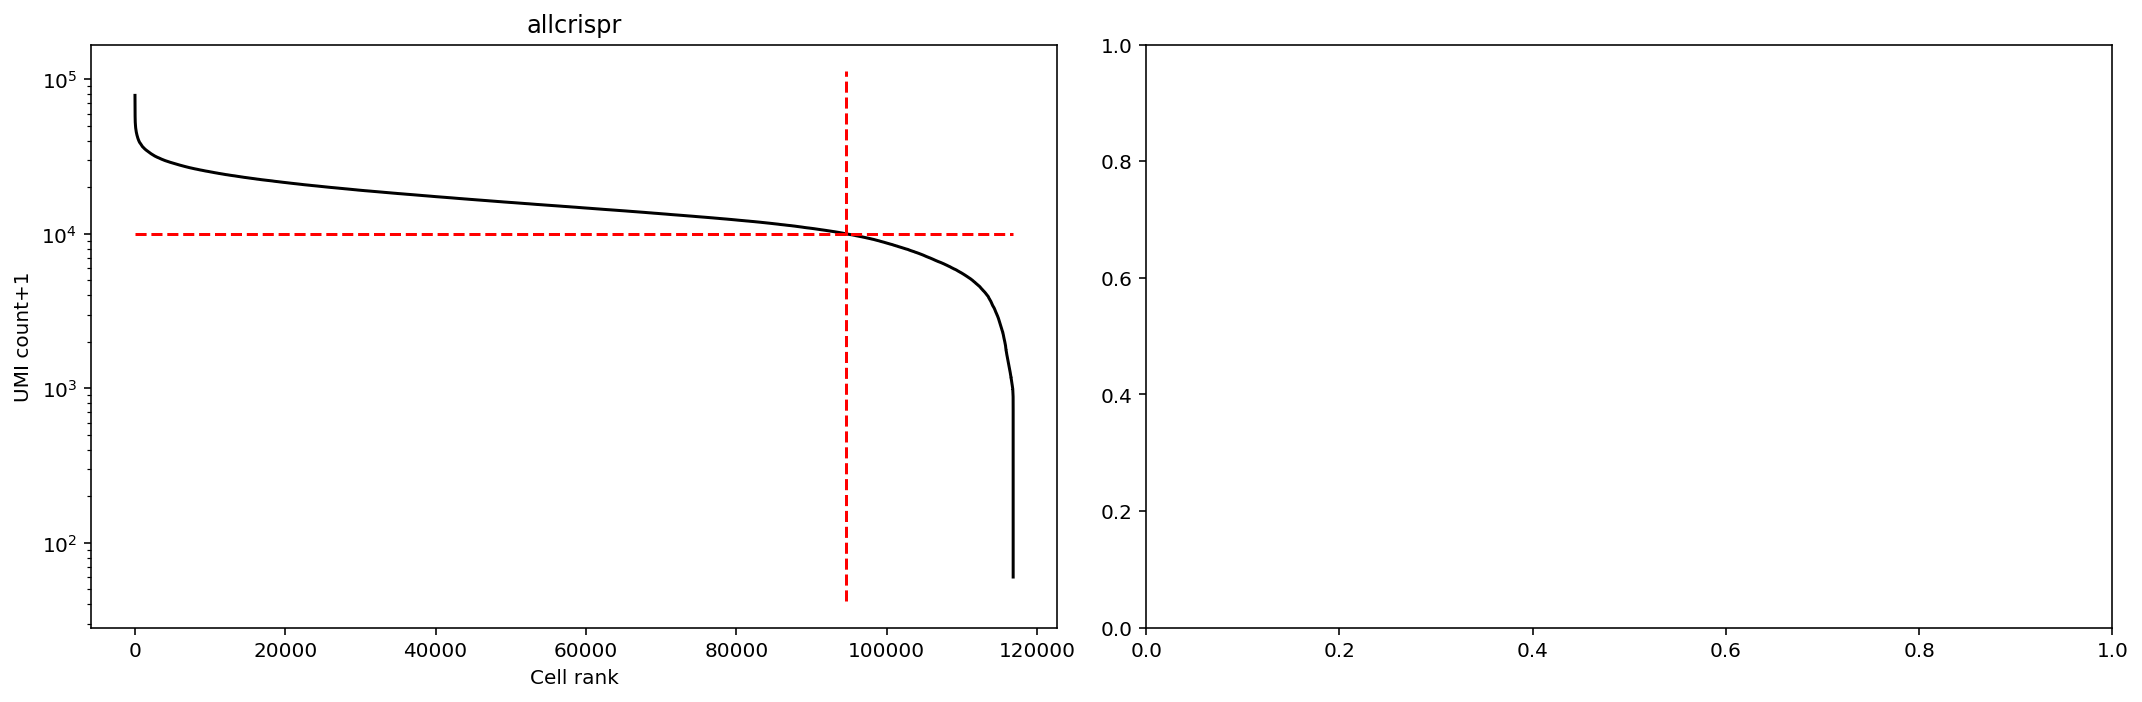

In [9]:
cf = []
thr_lb = [1e4]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['guide_identity'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_all_norman.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [11]:
#Conditions with too few cells after filtering
ok = []
okinds = []
for i in range(len(subcluster_names)):
    x = cf[i]
    if x.sum() > 50:
        ok += [subcluster_names[i]]
        okinds += [i]
print(len(ok))

277


In [17]:
#re-filter
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [i for i in ok]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

cf = np.array(cf)[okinds]

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0', 'norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1', 'norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0', 'norman_allcrispr_TBX3_TBX2__TBX3_TBX2', 'norman_allcrispr_SLC4A1_NegCtrl0__SLC4A1_NegCtrl0', 'norman_allcrispr_ETS2_CNN1__ETS2_CNN1', 'norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2', 'norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2', 'norman_allcrispr_NegCtrl0_BAK1__NegCtrl0_BAK1', 'norman_allcrispr_NegCtrl0_KLF1__NegCtrl0_KLF1', 'norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2', 'norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0', 'norman_allcrispr_BAK1_NegCtrl0__BAK1_NegCtrl0', 'norman_allcrispr_SET_KLF1__SET_KLF1', 'norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE', 'norman_allcrispr_CBL_NegCtrl0__CBL_NegCtrl0', 'norman_allcri

In [20]:
cf = list(cf)

## **Gene Filtering**

In [21]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [22]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230213_025_norman_crispr_all_1 created.
INFO:root:Dataset: norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0
INFO:root:3255 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:2584 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230213_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0 created.
INFO:root:Dataset: norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0
INFO:root:2679 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:2466 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230213_025_norman_crispr_all_1/norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0 created.
INFO:root:Dataset: norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0
INFO:root:2622 cells detected.
INFO:root:36601 features obs

/home/ggorin/projects/monod/src/monod/preprocess.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:605 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:1454 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230213_025_norman_crispr_all_1/norman_allcrispr_ZNF318_NegCtrl0__ZNF318_NegCtrl0 created.
INFO:root:Dataset: norman_allcrispr_LHX1_ELMSAN1__LHX1_ELMSAN1
INFO:root:536 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:1289 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230213_025_norman_crispr_all_1/norman_allcrispr_LHX1_ELMSAN1__LHX1_ELMSAN1 created.
INFO:root:Dataset: norman_allcrispr_FOSB_NegCtrl0__FOSB_NegCtrl0
INFO:root:561 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:1416 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230213_025_norman_crispr_all_1/norman_allcrispr_FOSB_NegCtrl0__FOSB_NegCtrl0 created.
INFO:root

KeyboardInterrupt: 

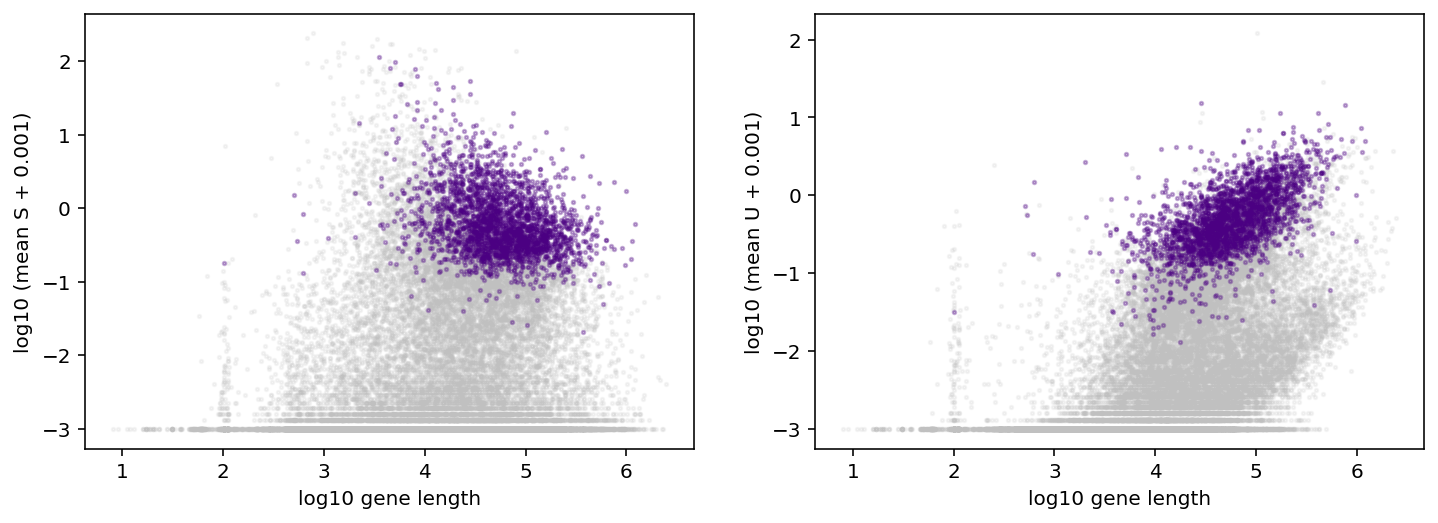

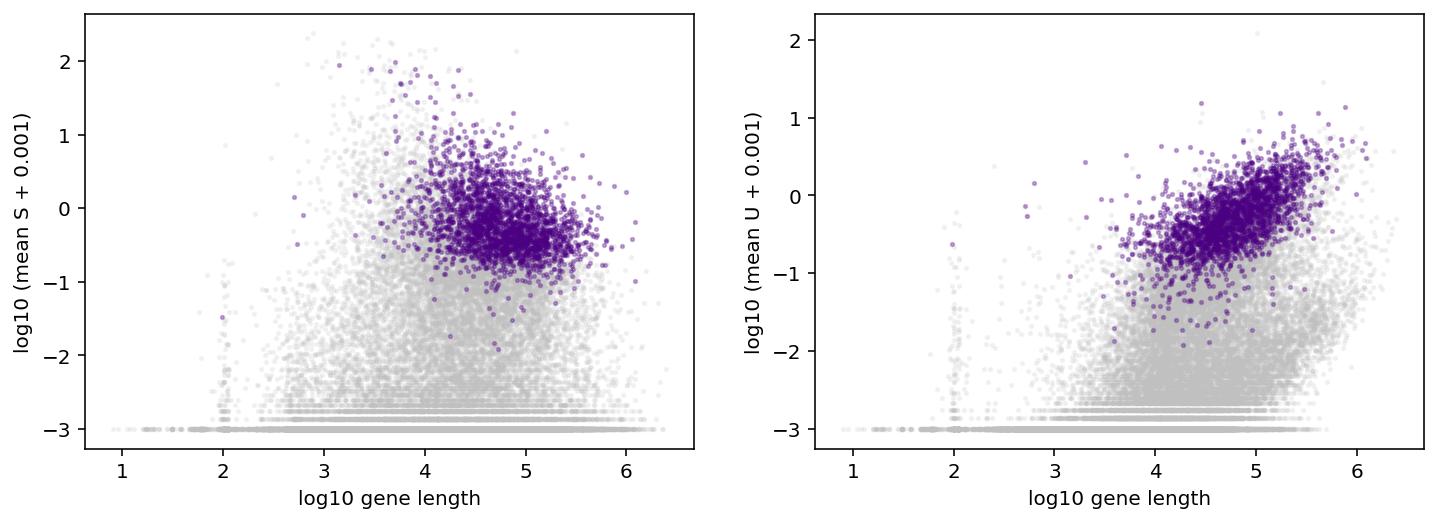

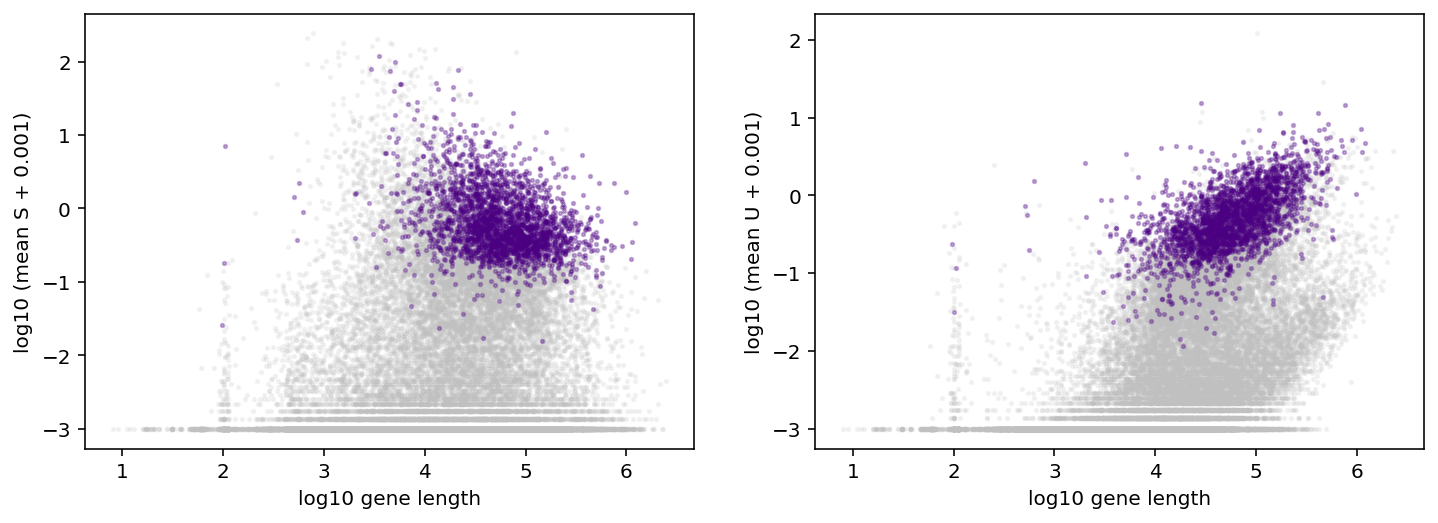

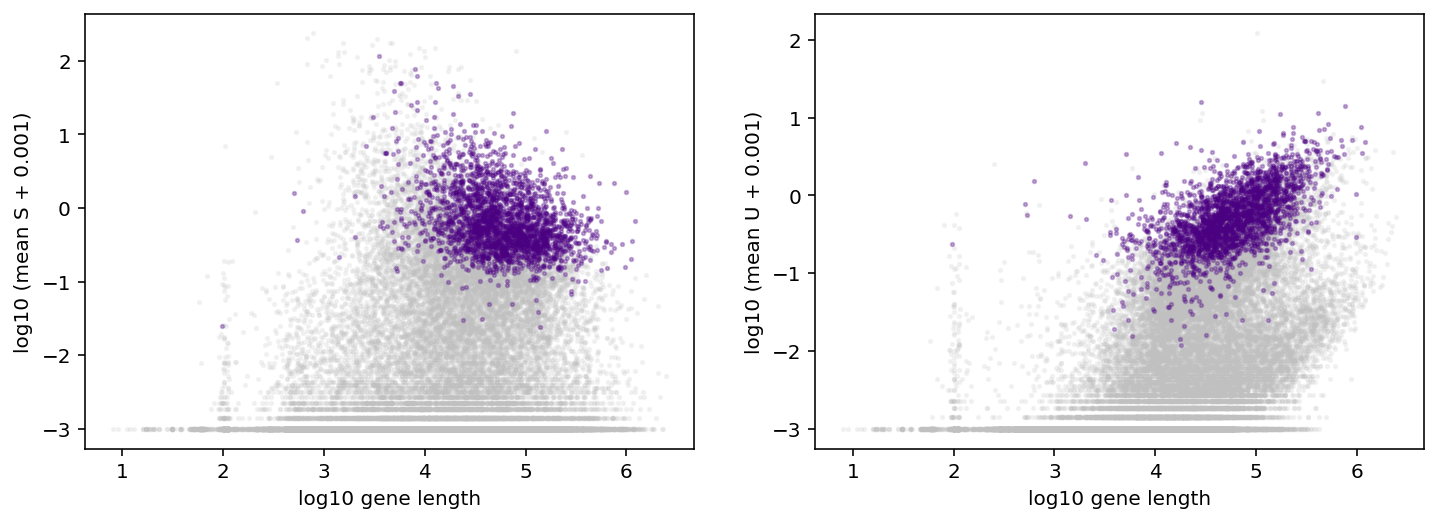

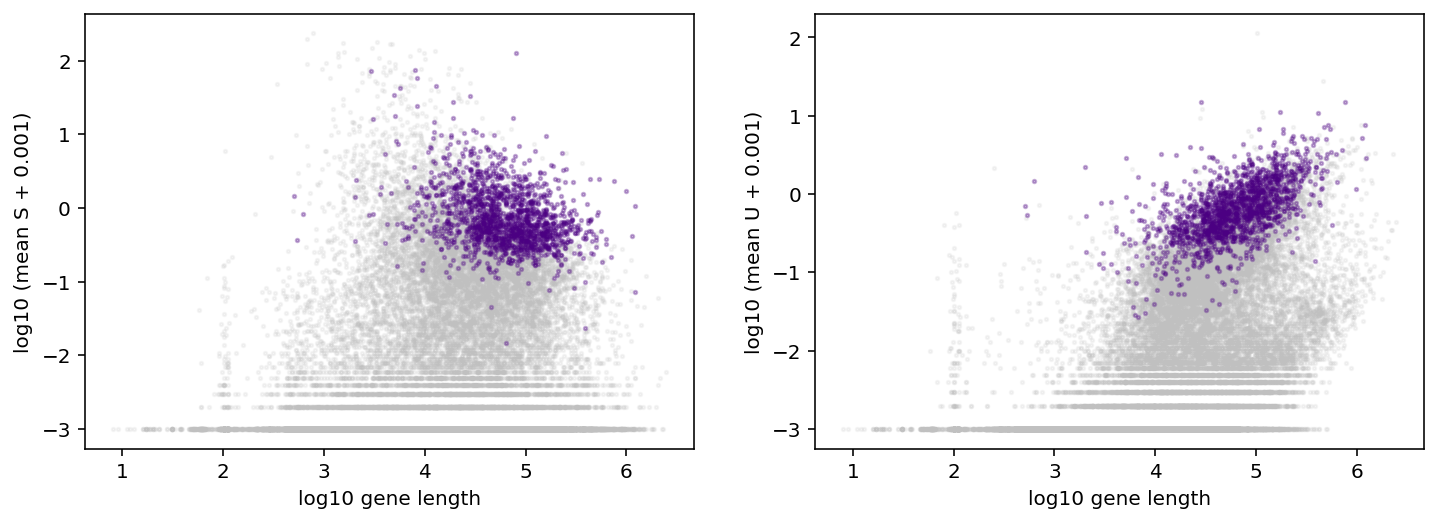

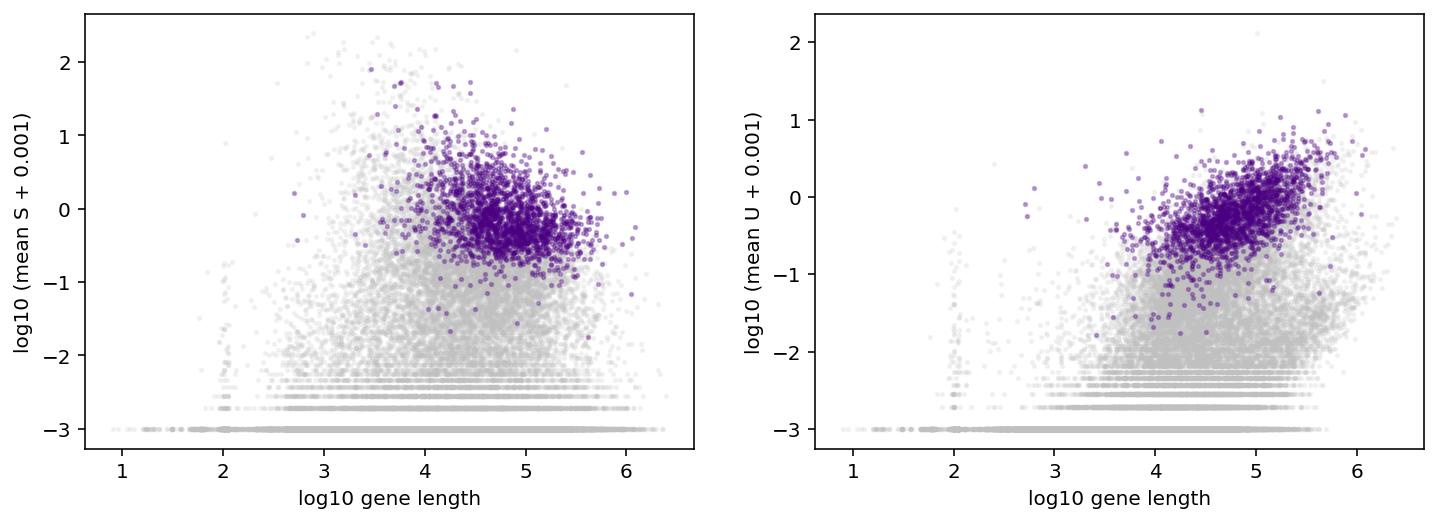

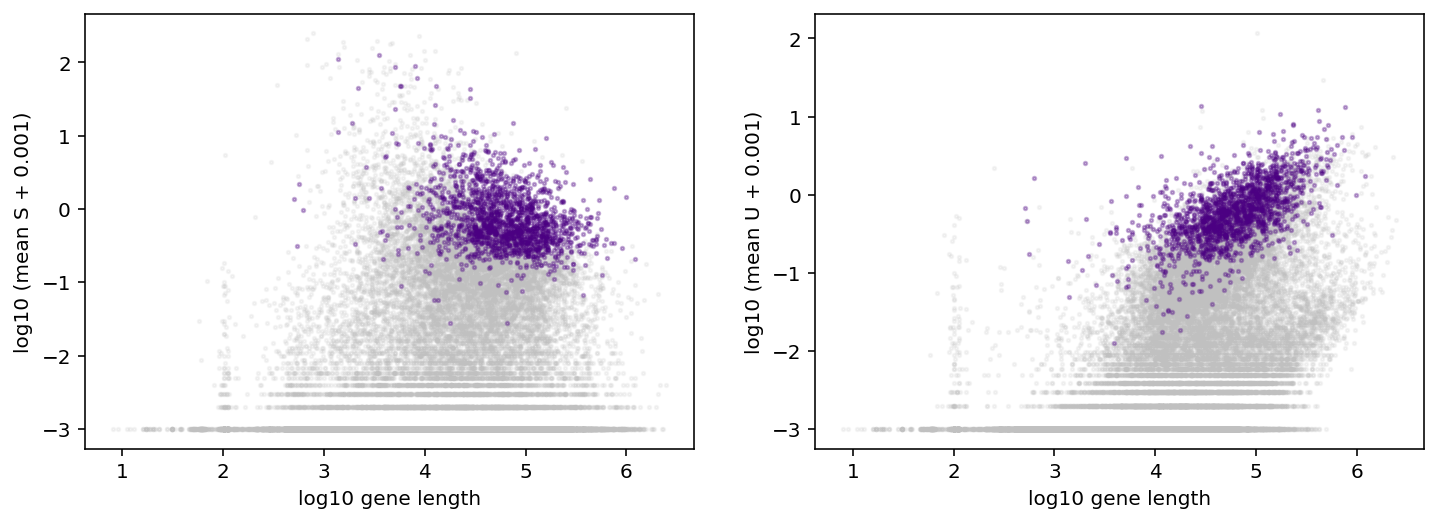

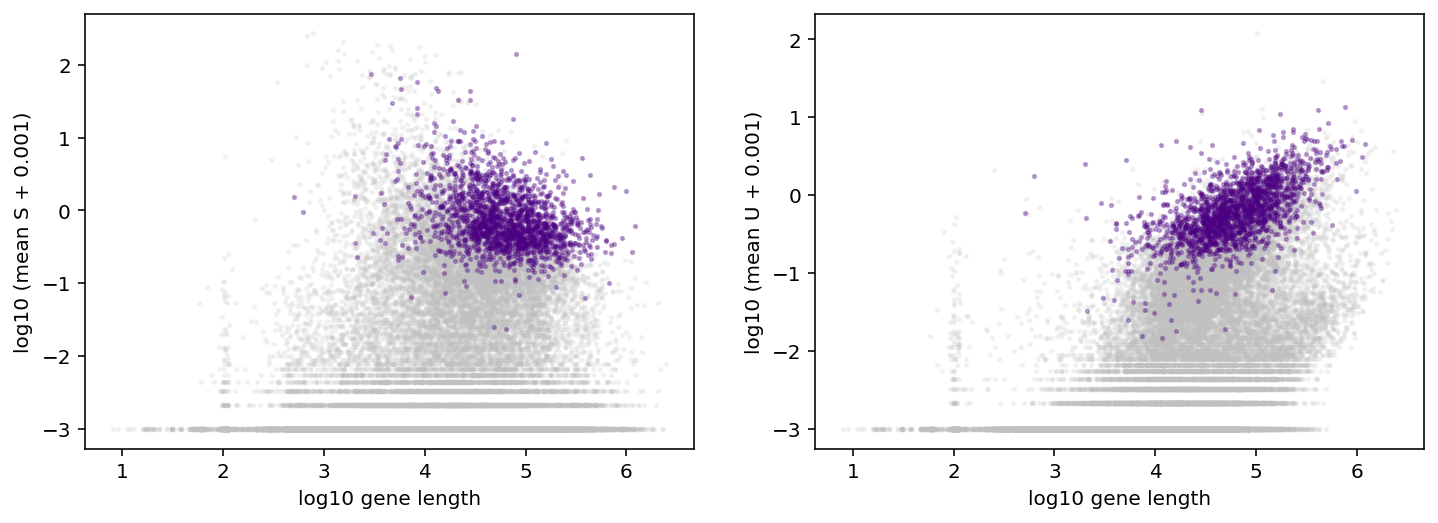

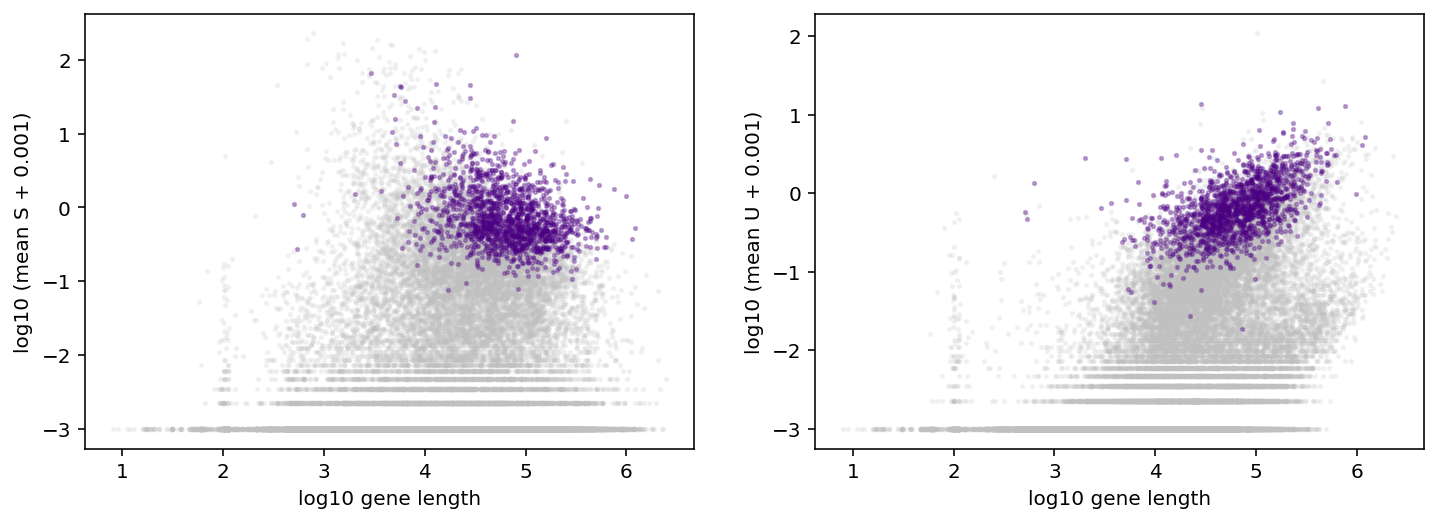

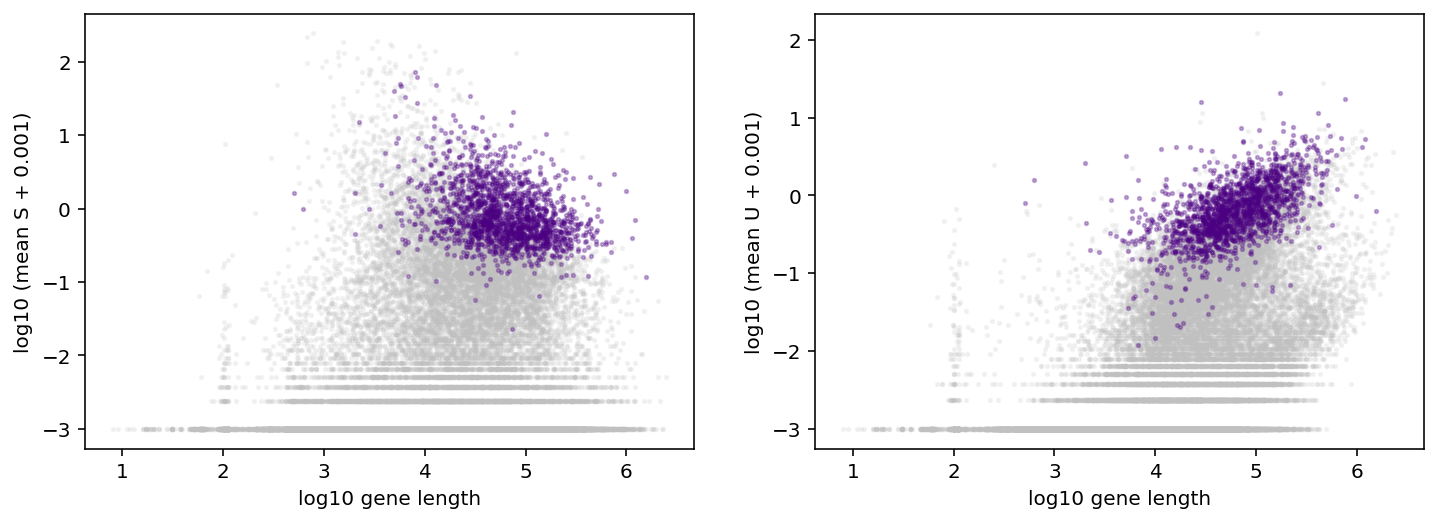

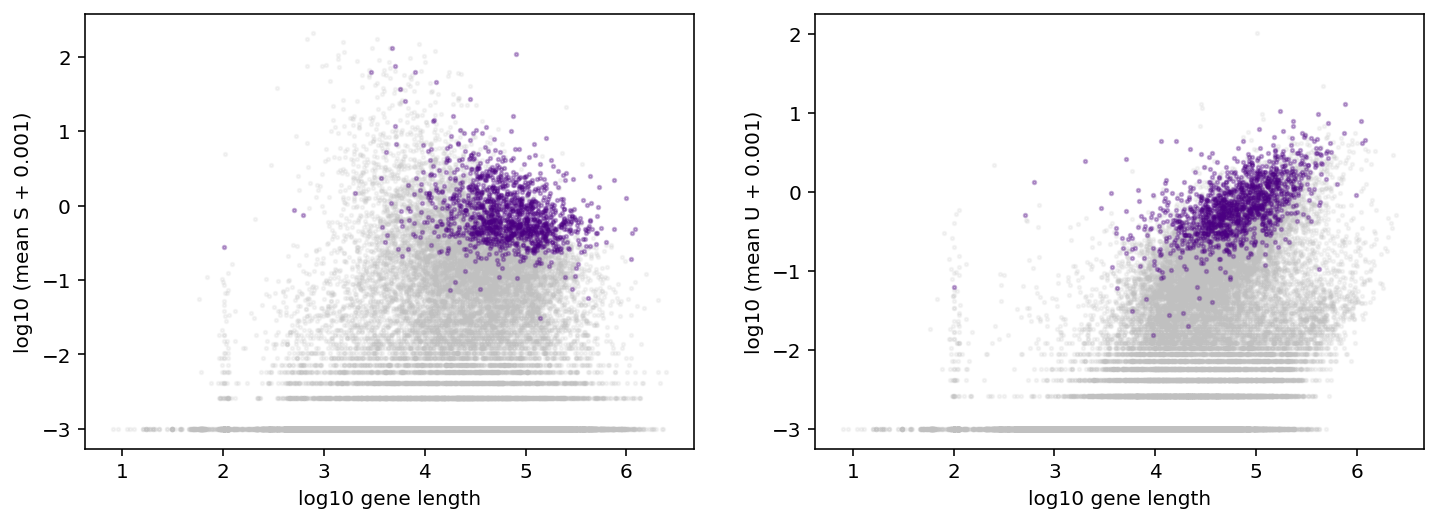

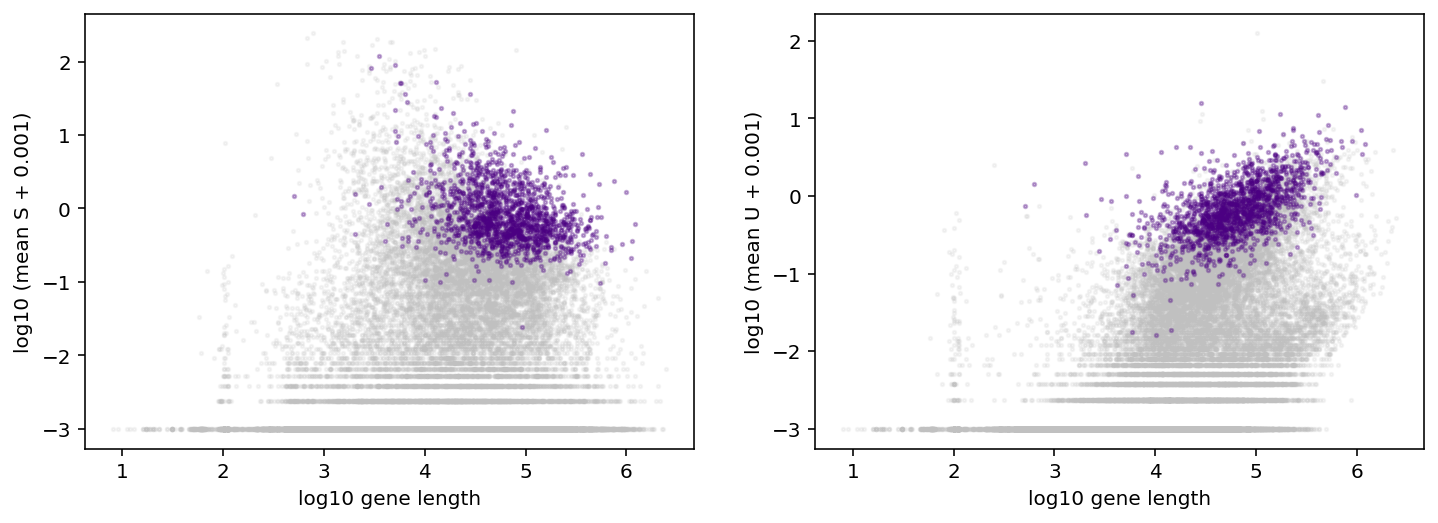

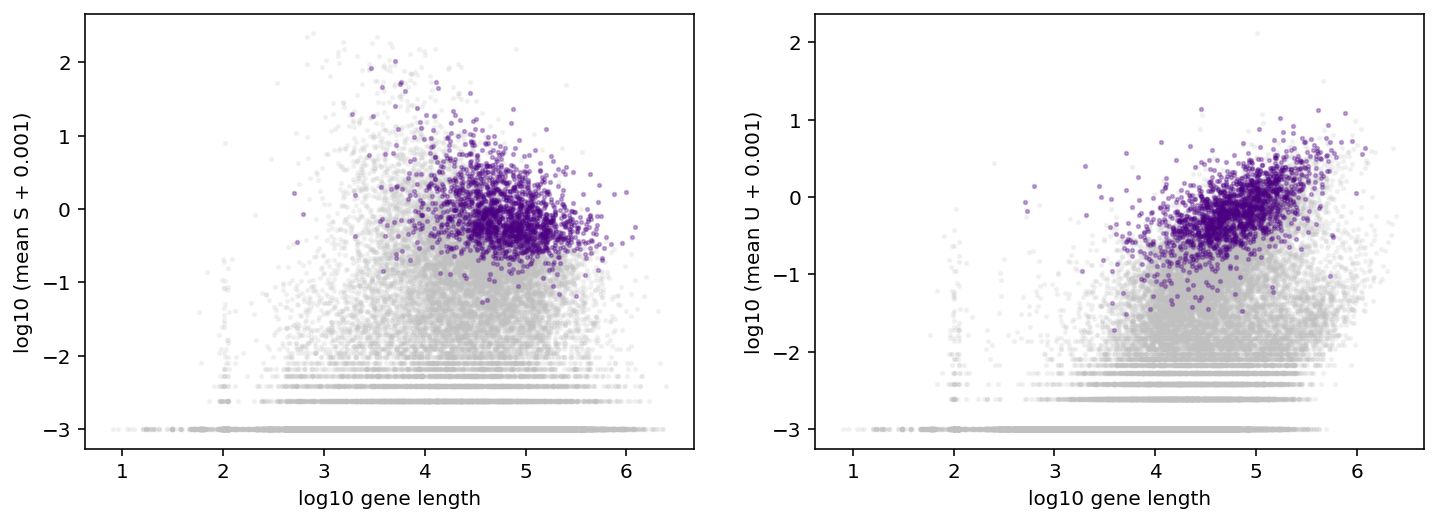

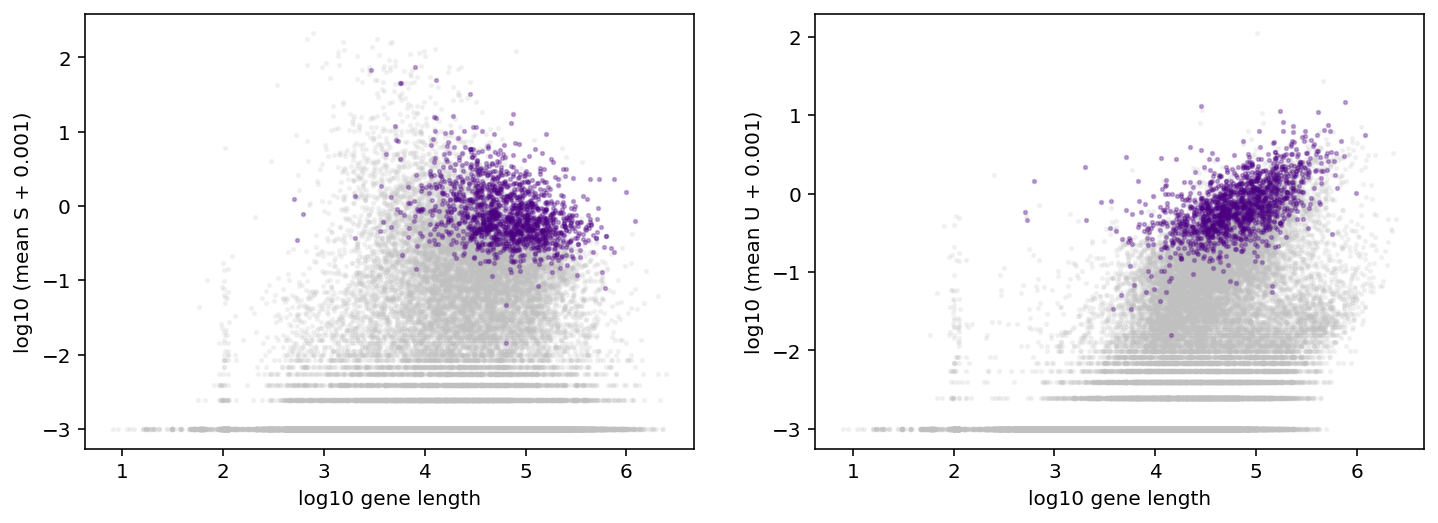

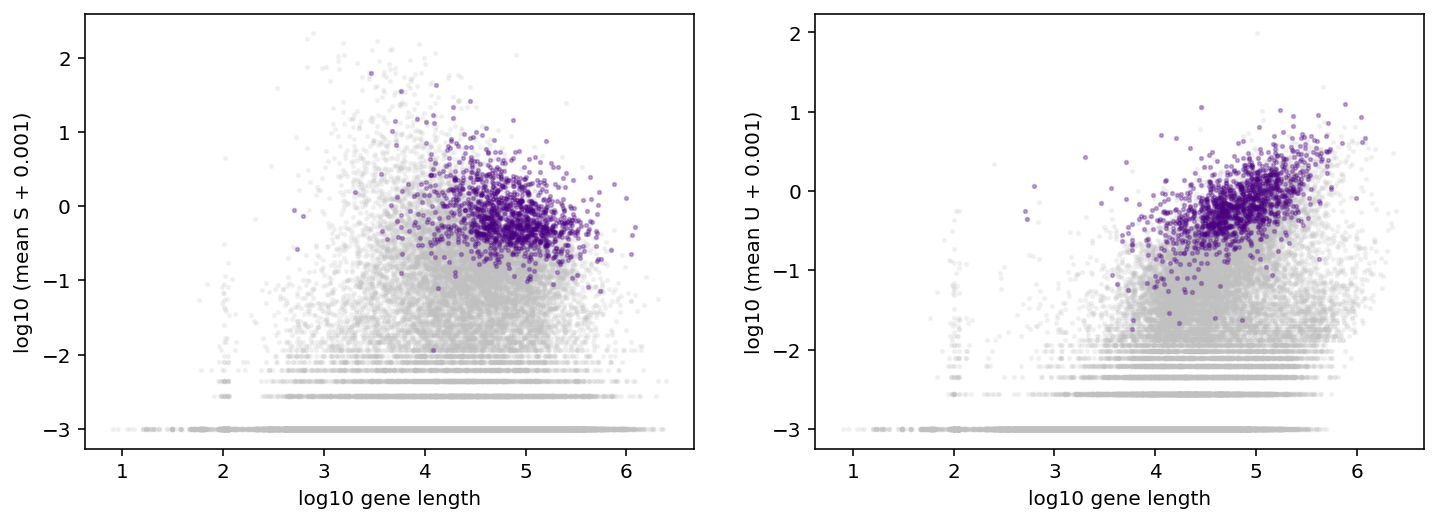

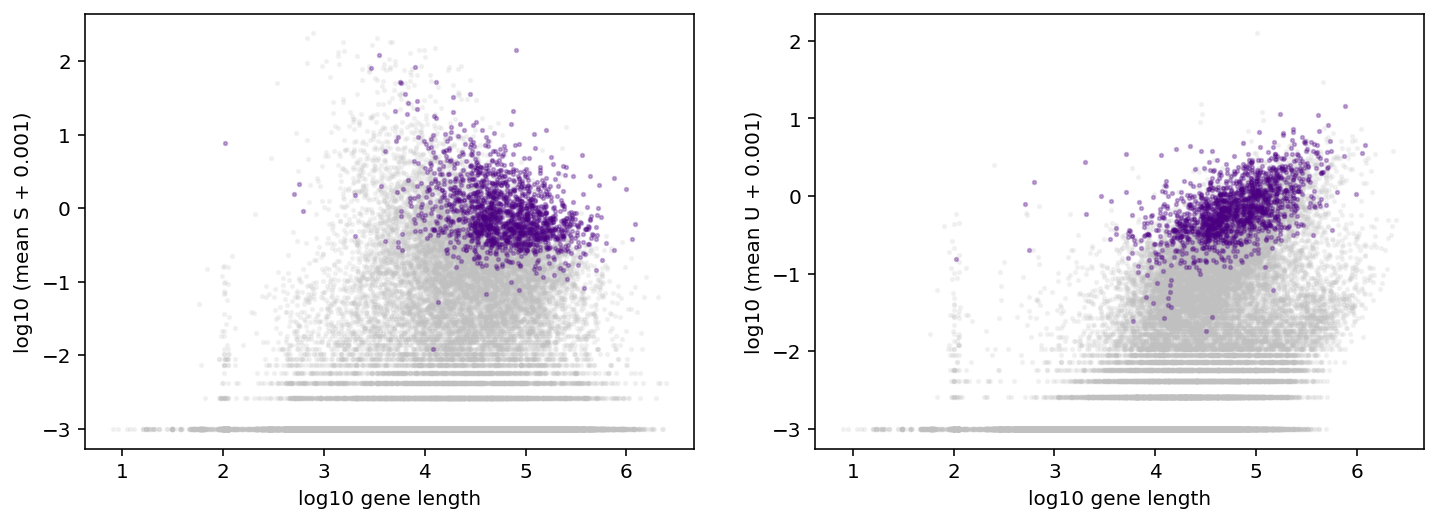

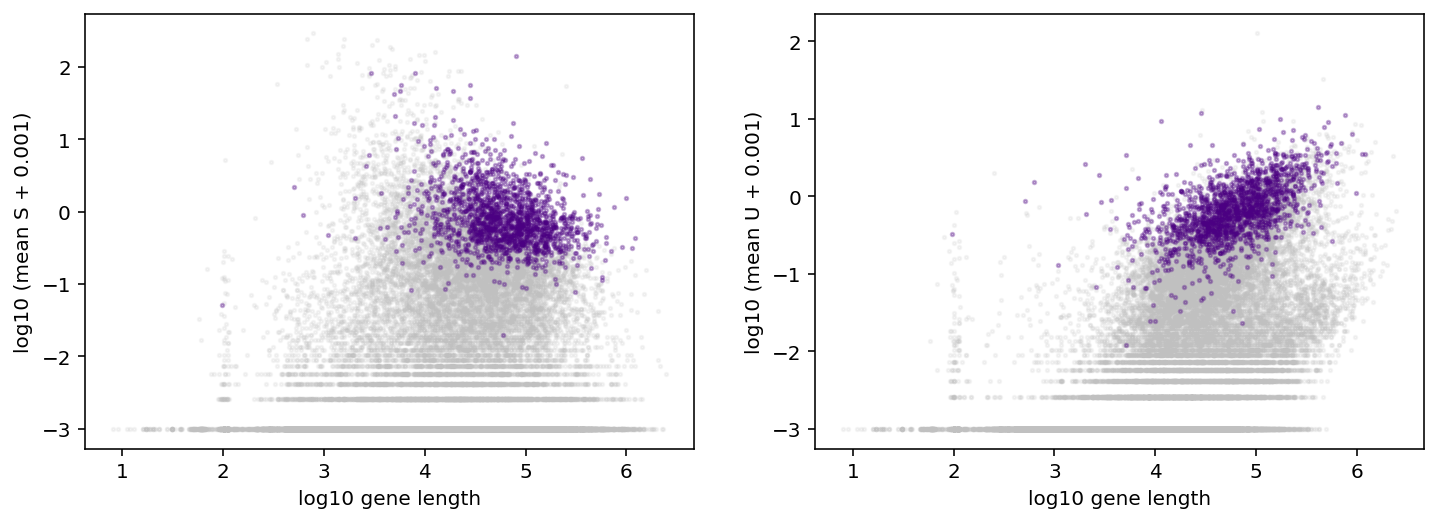

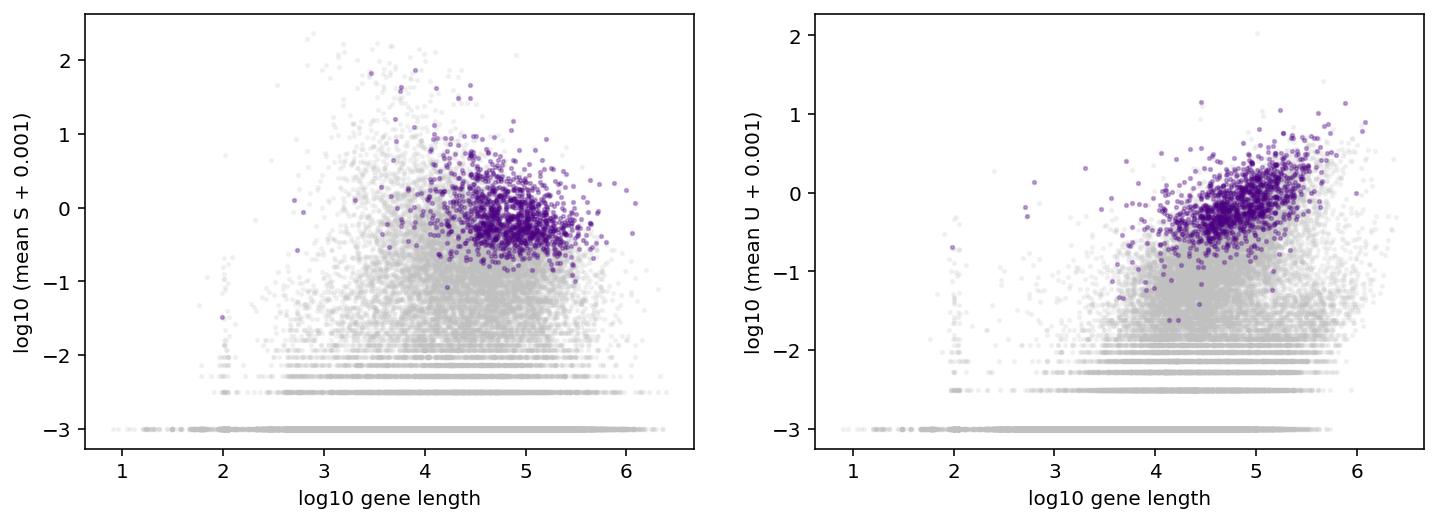

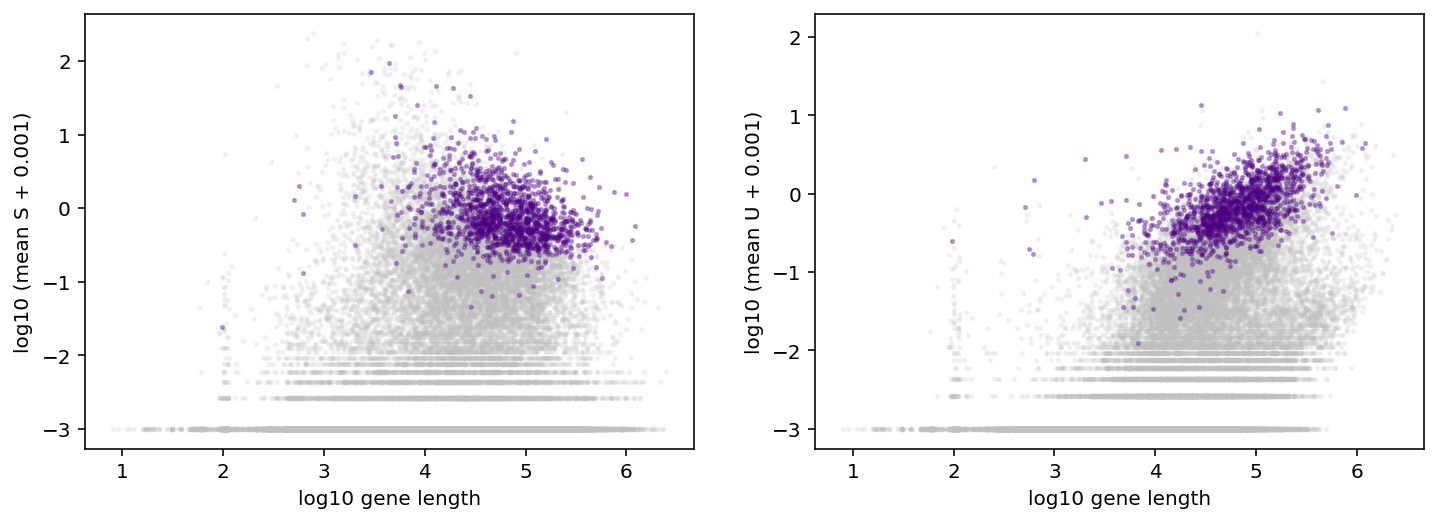

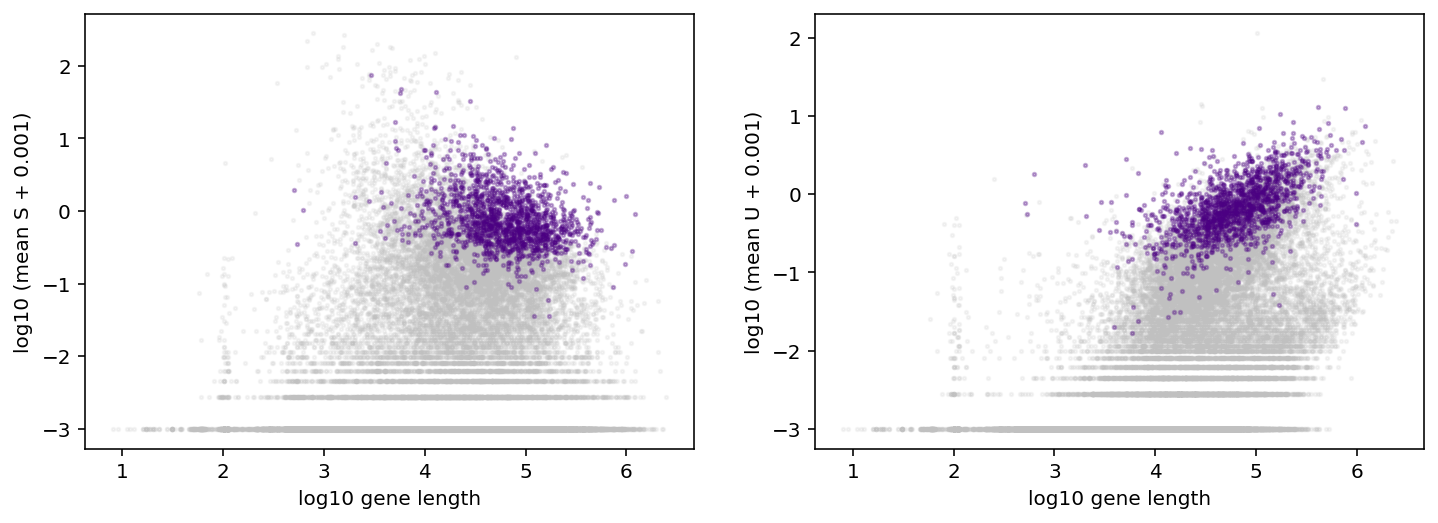

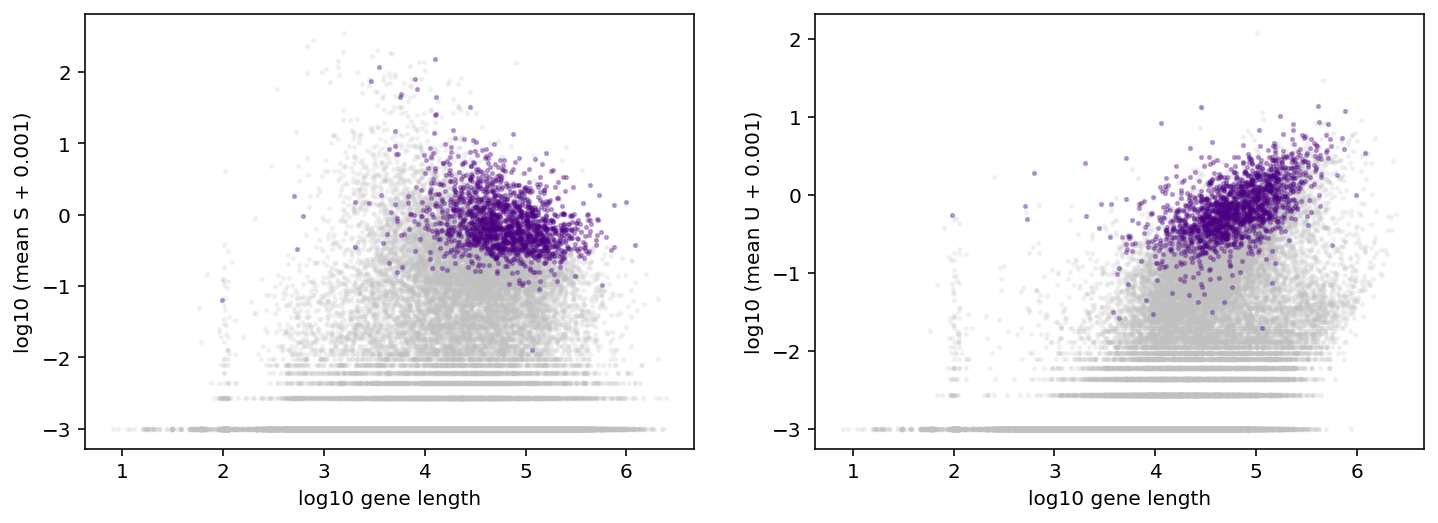

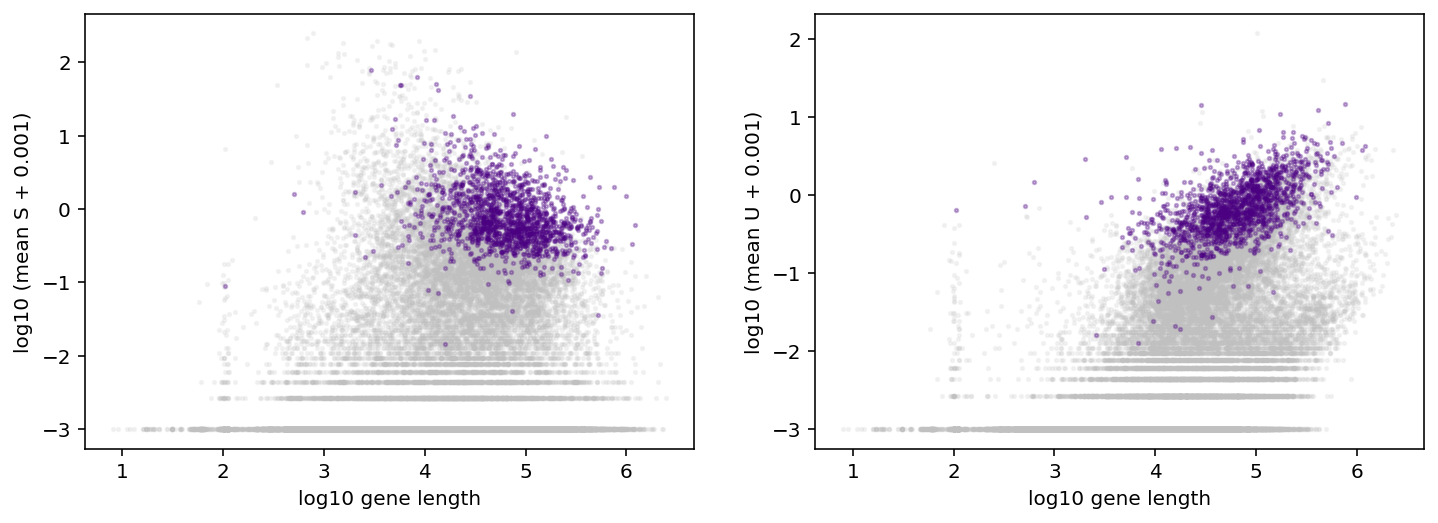

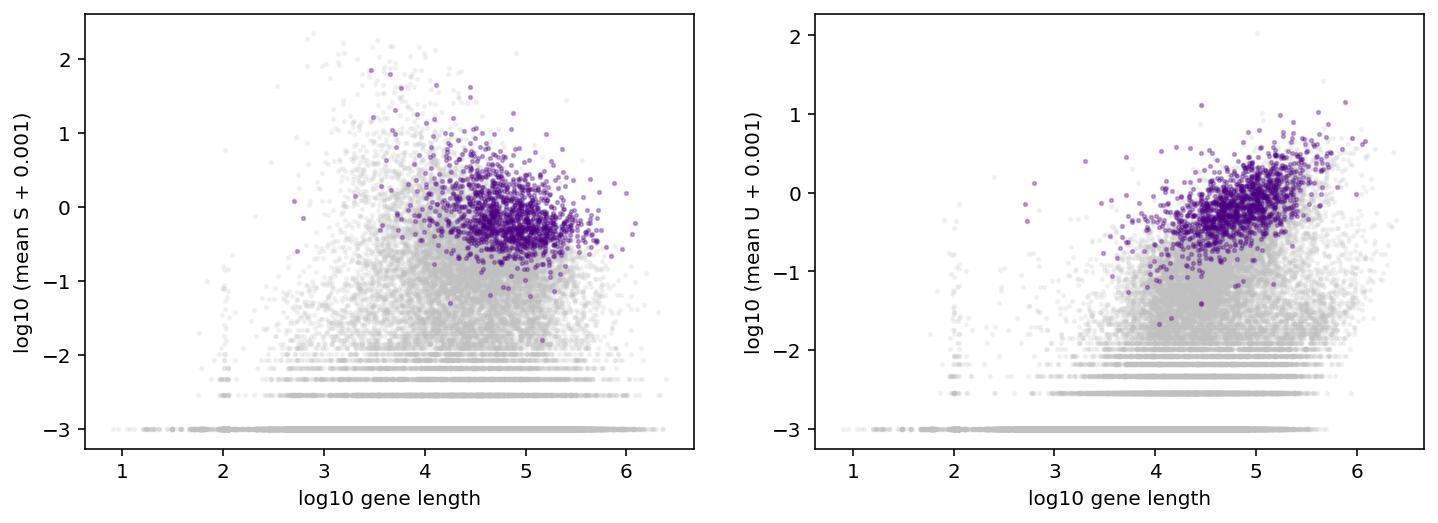

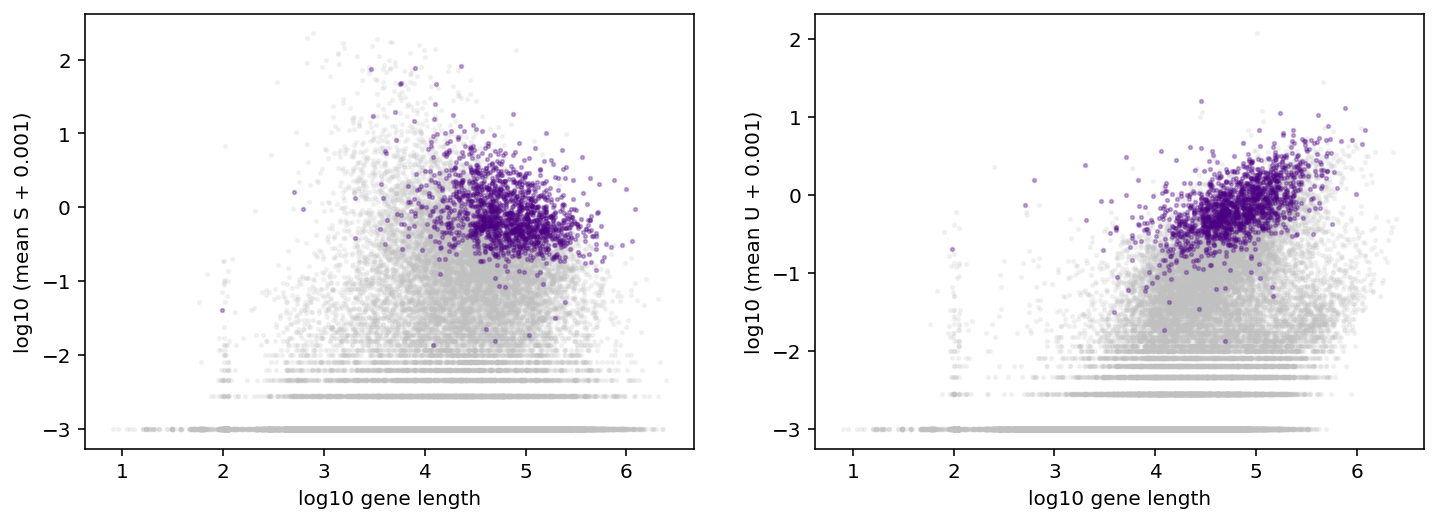

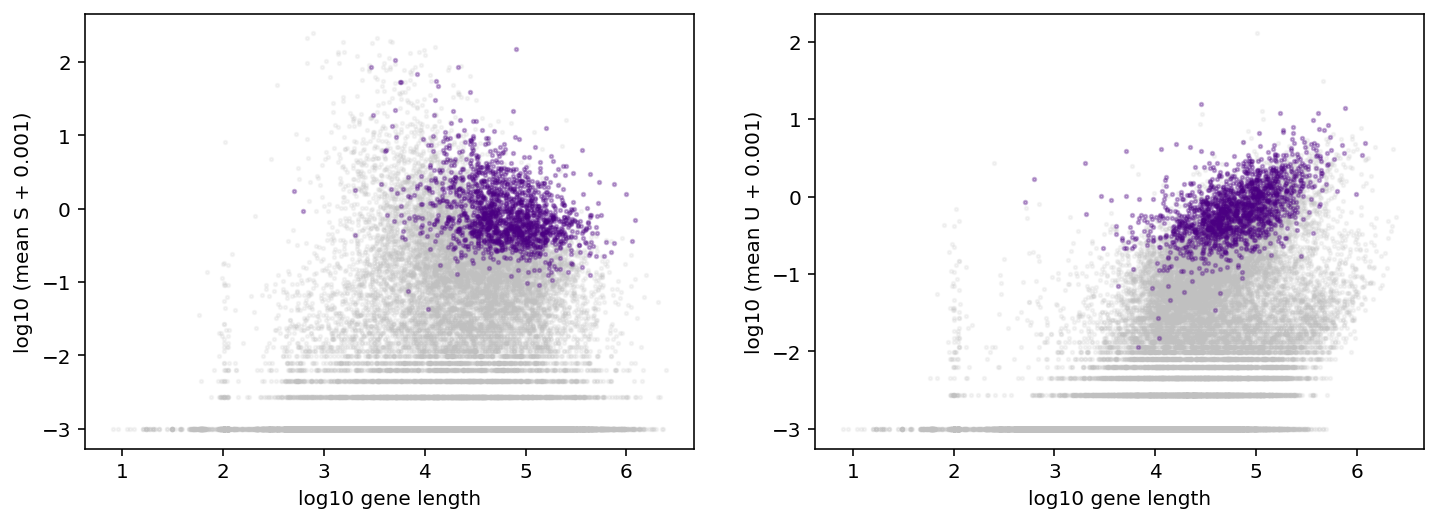

In [23]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='norman_crispr_all',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

In [ ]:
dir_string

In [ ]:
dataset_strings

In [ ]:
dir_string = 

In [ ]:
dataset_strings = 

## **Inference**

In [ ]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


In [ ]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':5})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(60,search_data)

    result_strings.append(full_result_string)

In [ ]:
result_strings

In [ ]:
result_strings = 